In [81]:
import geopandas as gpd
import numpy as np
import pandas as pd
import ee
import geemap
from datetime import datetime
from pathlib import Path
from osgeo import gdal

import rioxarray
import glob

import shutil
import matplotlib.pyplot as plt
import hashlib
import os

In [82]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

In [83]:
#FIRST PART OF JM'S NOTEBOOK, shortened

# If you're doing watersheds
HYBAS_ID = 3100979030
aoi_name = str(HYBAS_ID)


aoi_path = Path('/sciclone/data10/watersheds', str(aoi_name))
Path(Path(aoi_path)).mkdir(parents=True, exist_ok=True)


aoi = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_10").filter(ee.Filter.eq('HYBAS_ID', HYBAS_ID))
longitude = aoi.geometry().centroid().coordinates().get(0).getInfo()
latitude = aoi.geometry().centroid().coordinates().get(1).getInfo()


#New stuff, starting with ALIGN

aligned_path = Path(aoi_path, 'aligned')
Path(aligned_path).mkdir(parents=True, exist_ok=True)

# Save your generator object
tif_list = list(aoi_path.glob('*.tif'))
ds_list = []
res_flag = 'max'
print(tif_list)



for tif in tif_list:
    src = rioxarray.open_rasterio(tif).astype('float32')
    src.attrs['_FillValue'] = np.nan
    ds_list.append(src)

res_list = [src.rio.transform()[0] for src in ds_list]

if res_flag == 'min':
    to_align = ds_list[:(res_list).index(min(res_list))] + ds_list[(res_list).index(min(res_list)) + 1:]
    to_name = tif_list[:(res_list).index(min(res_list))] + tif_list[(res_list).index(min(res_list)) + 1:]
    for i, src in enumerate(to_align):
        aligned = src.rio.reproject_match(ds_list[(res_list).index(min(res_list))]).rio.to_raster(Path(aligned_path, to_name[i].name))
elif res_flag == 'max':
    to_align = ds_list[:(res_list).index(max(res_list))] + ds_list[(res_list).index(max(res_list)) + 1:]
    to_name = tif_list[:(res_list).index(max(res_list))] + tif_list[(res_list).index(max(res_list)) + 1:]
    for i, src in enumerate(to_align):
        aligned = src.rio.reproject_match(ds_list[(res_list).index(max(res_list))]).rio.to_raster(Path(aligned_path, to_name[i].name))

source = [source_name for source_name in set(tif_list).difference(to_name)][0]
source_path = Path(source)
destination_path = Path(aligned_path) / source_path.name
shutil.copy(source_path, destination_path)

[PosixPath('/sciclone/data10/watersheds/3100979030/3100979030_2019-06-09_RGB.tif'), PosixPath('/sciclone/data10/watersheds/3100979030/3100979030_2019-06-09_NDVI.tif'), PosixPath('/sciclone/data10/watersheds/3100979030/3100979030_2019-06-09_ArcticDEM.tif')]


PosixPath('/sciclone/data10/watersheds/3100979030/aligned/3100979030_2019-06-09_RGB.tif')

Reading /sciclone/data10/watersheds/3100979030/aligned/3100979030_2019-06-09_NDVI.tif
Total number of pixels with ninja value in /sciclone/data10/watersheds/3100979030/aligned/3100979030_2019-06-09_NDVI.tif: 1012755
Reading /sciclone/data10/watersheds/3100979030/aligned/3100979030_2019-06-09_ArcticDEM.tif
Total number of pixels with ninja value in /sciclone/data10/watersheds/3100979030/aligned/3100979030_2019-06-09_ArcticDEM.tif: 2805678
No variation in data for /sciclone/data10/watersheds/3100979030/aligned/3100979030_2019-06-09_ArcticDEM.tif, skipping file.
Reading /sciclone/data10/watersheds/3100979030/aligned/3100979030_2019-06-09_RGB.tif
Total number of pixels with ninja value in /sciclone/data10/watersheds/3100979030/aligned/3100979030_2019-06-09_RGB.tif: 0


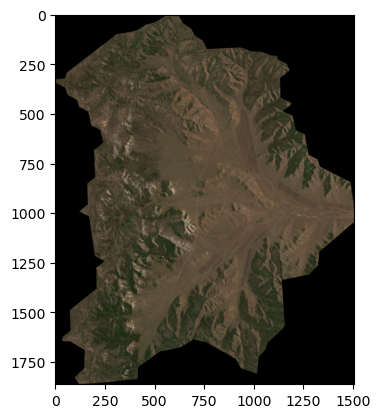

In [84]:
input_dir = Path(aligned_path)
unit_dir = Path(aoi_path, 'aligned', 'uint8')
unit_dir.mkdir(parents=True, exist_ok=True)
geotiff_files = list(input_dir.glob('*.tif'))

rgb_tif_files = list(input_dir.glob('*RGB*.tif'))    #added for excel stuff

ninja_value = 0.0123456789

excess_nan_dir = Path(aoi_path, 'aligned', 'Excess_NaN')
excess_nan_dir.mkdir(parents=True, exist_ok=True)

for geotiff_file in geotiff_files:
    input_path = str(geotiff_file)
    print(f'Reading {input_path}')
    # Open the input GeoTIFF file
    src_ds = gdal.Open(input_path)
    if src_ds is None:
        print(f"Failed to open {input_path}")
        continue

    # Read the data as Float32
    float32_data = src_ds.ReadAsArray()

   # Replacing NaN values with Ninja value
    float32_data = np.nan_to_num(float32_data, nan=ninja_value)

    # Making sure there are no infinite values
    float32_data[np.isinf(float32_data)] = ninja_value

    # Count the number of pixels with the ninja value
    ninja_pixel_count = np.sum(float32_data == ninja_value)
    print(f"Total number of pixels with ninja value in {input_path}: {ninja_pixel_count}")

    # Calculating the min and max, ensuring no NaNs are included
    data_min = np.nanmin(float32_data)
    data_max = np.nanmax(float32_data)

    if data_min == data_max:
        print(f"No variation in data for {input_path}, skipping file.")
        continue

    # Scale and convert the data to UInt8
    uint8_data = (float32_data - data_min) / (data_max - data_min)
    uint8_data = (uint8_data * 255).astype(np.uint8)

    # Create a new GeoTIFF file with UInt8 data
    output_path = unit_dir / geotiff_file.name
    ds = gdal.GetDriverByName('GTiff').Create(
        str(output_path),
        src_ds.RasterXSize,
        src_ds.RasterYSize,
        src_ds.RasterCount,  # Number of bands
        gdal.GDT_Byte  # Data type: UInt8
    )

    # Write the UInt8 data to the bands
    if src_ds.RasterCount == 1:
        ds.GetRasterBand(1).WriteArray(uint8_data)
    else:
        for band_num in range(1, src_ds.RasterCount + 1):
            ds.GetRasterBand(band_num).WriteArray(uint8_data[band_num - 1])

    # Set the original spatial reference
    ds.SetProjection(src_ds.GetProjection())
    ds.SetGeoTransform(src_ds.GetGeoTransform())

    ds.FlushCache()

    # Close the datasets
    ds = None
    src_ds = None



# plt.imshow(((float32_data - np.nanmin(float32_data)) / (np.nanmax(float32_data) - np.nanmin(float32_data)) * 255).astype(np.uint8))

# Assuming float32_data is in shape (bands, height, width)
normalized_data = ((float32_data - np.nanmin(float32_data)) / (np.nanmax(float32_data) - np.nanmin(float32_data)) * 255).astype(np.uint8)

# Transpose the data to get it in the shape (height, width, bands)
transposed_data = normalized_data.transpose(1, 2, 0)

plt.imshow(transposed_data)
plt.show()

# plt.imshow(((float32_data - np.nanmin(float32_data)) / (np.nanmax(float32_data) - np.nanmin(float32_data)) * 255).astype(np.uint8))


In [85]:
valid_rgb_tile_count = 0

def split_into_jpeg_tiles(input_path, output_dir, tile_size, ninja_value, excess_nan_dir):
    global valid_rgb_tile_count    #added for excel stuff by you
    fname = input_path.stem
    output_format = 'JPEG'
    creation_options = ['QUALITY=95']
    input_path = Path(input_path)
    output_dir = Path(output_dir)
    src_ds = gdal.Open(str(input_path))
    width = src_ds.RasterXSize
    height = src_ds.RasterYSize
    print(f"{fname} is {width} x {height}")

    cols = width // tile_size
    rows = height // tile_size

    for row in range(rows):
        for col in range(cols):
            x_offset = col * tile_size
            y_offset = row * tile_size

            tile_width = min(tile_size, width - x_offset)
            tile_height = min(tile_size, height - y_offset)

            tile_data = src_ds.ReadAsArray(x_offset, y_offset, tile_width, tile_height)

            if tile_data.ndim == 3:
                # For multi-band (RGB) images
                transposed_data = tile_data.transpose(1, 2, 0)
                black_pixel_count = np.sum(np.all(transposed_data == [0, 0, 0], axis=-1))
            else:
                # For single-band images
                black_pixel_count = np.sum(tile_data == 0)

            print(f"Tile at row {row}, col {col} has {black_pixel_count} black pixels")

            total_count = tile_width * tile_height * src_ds.RasterCount
            valid_count = total_count - black_pixel_count
            valid_percentage = (valid_count / total_count) * 100

            if valid_percentage < 95 or (black_pixel_count / total_count) >= 0.05:
                print(f"Moving tile at row {row}, col {col} to Excess_NaN due to black pixel percentage")
                output_file = excess_nan_dir / f"{fname}_{row}_{col}.jpeg"
            else:
                output_file = output_dir / f"{fname}_{row}_{col}.jpeg"
                valid_rgb_tile_count += 1

            ds = gdal.Translate(
                str(output_file),
                str(input_path),
                srcWin=[x_offset, y_offset, tile_width, tile_height],
                format=output_format,
                width=tile_width,
                height=tile_height,
                creationOptions=creation_options
            )

            ds = None

    src_ds = None

# Define paths and initialize variables
input_dir = Path(aligned_path)
unit_dir = Path(aoi_path, 'aligned', 'uint8')
unit_dir.mkdir(parents=True, exist_ok=True)
geotiff_files = list(input_dir.glob('*RGB*.tif'))  # Only process RGB files

ninja_value = 0.0

excess_nan_dir = Path(aoi_path, 'aligned', 'Excess_NaN')
excess_nan_dir.mkdir(parents=True, exist_ok=True)


In [86]:
# Was messing around with this deleting duplicates but didn't go with it. 
# If you don't delete duplicate files or everything in aligned, you get an error involving bands.

# # Delete duplicate files 
# def delete_duplicate_files(directory):
#     def calculate_md5(file_path):
#         import hashlib
#         hash_md5 = hashlib.md5()
#         with open(file_path, "rb") as f:
#             for chunk in iter(lambda: f.read(4096), b""):
#                 hash_md5.update(chunk)
#         return hash_md5.hexdigest()

#     file_hashes = {}
#     for root, _, files in os.walk(directory):
#         for file in files:
#             file_path = os.path.join(root, file)
#             file_hash = calculate_md5(file_path)
#             if file_hash in file_hashes:
#                 print(f"Deleting duplicate file: {file_path}")
#                 os.remove(file_path)
#             else:
#                 file_hashes[file_hash] = file_path

# delete_duplicate_files(aligned_path)

tif_list = list(unit_dir.glob('*.tif'))

tile_size = 256

output_directory = unit_dir / 'jpegs'
output_directory.mkdir(parents=True, exist_ok=True)

for tif in tif_list:
    input_geotiff = tif
    split_into_jpeg_tiles(input_geotiff, output_directory, tile_size, ninja_value, excess_nan_dir)

Deleting duplicate file: /sciclone/data10/watersheds/3100979030/aligned/uint8/3100979030_2019-06-09_NDVI.tif
3100979030_2019-06-09_RGB is 1506 x 1863
Tile at row 0, col 0 has 57329 black pixels
Moving tile at row 0, col 0 to Excess_NaN due to black pixel percentage
Tile at row 0, col 1 has 21692 black pixels
Moving tile at row 0, col 1 to Excess_NaN due to black pixel percentage
Tile at row 0, col 2 has 14595 black pixels
Moving tile at row 0, col 2 to Excess_NaN due to black pixel percentage
Tile at row 0, col 3 has 44982 black pixels
Moving tile at row 0, col 3 to Excess_NaN due to black pixel percentage
Tile at row 0, col 4 has 59418 black pixels
Moving tile at row 0, col 4 to Excess_NaN due to black pixel percentage
Tile at row 1, col 0 has 21029 black pixels
Moving tile at row 1, col 0 to Excess_NaN due to black pixel percentage
Tile at row 1, col 1 has 0 black pixels
Tile at row 1, col 2 has 0 black pixels
Tile at row 1, col 3 has 0 black pixels
Tile at row 1, col 4 has 31988 bla

In [87]:
#EXCEL STUFF

# State the dimensions of the watershed
src_ds = gdal.Open(str(tif_list[0]))
width = src_ds.RasterXSize
height = src_ds.RasterYSize
print(f"Dimensions of the watershed: width = {width} pixels, height = {height} pixels")

# Convert the dimensions to km. Each pixel represents 0.01 km.
pixel_size_km = 0.01
width_km = width * pixel_size_km
height_km = height * pixel_size_km
print(f"Dimensions of the watershed: width = {width_km} km, height = {height_km} km")

# Calculate the area of the watershed
area_watershed_km2 = width_km * height_km
print(f"Area of the watershed: {area_watershed_km2:.2f} km^2")

# Add a line stating the total number of valid tiles
print(f"Total number of valid RGB tiles: {valid_rgb_tile_count}")

# Calculate the area that the valid tiles occupy
area_tile_km2 = (tile_size * pixel_size_km) ** 2
area_valid_tiles_km2 = valid_rgb_tile_count * area_tile_km2
print(f"Area occupied by valid RGB tiles: {area_valid_tiles_km2:.2f} km^2")

# Calculate the percentage of the watershed accounted for in the valid tiles
percentage_valid_tiles = (area_valid_tiles_km2 / area_watershed_km2) * 100
print(f"Percentage of the watershed accounted for in the valid RGB tiles: {percentage_valid_tiles:.2f}%")

Dimensions of the watershed: width = 1506 pixels, height = 1863 pixels
Dimensions of the watershed: width = 15.06 km, height = 18.63 km
Area of the watershed: 280.57 km^2
Total number of valid RGB tiles: 19
Area occupied by valid RGB tiles: 124.52 km^2
Percentage of the watershed accounted for in the valid RGB tiles: 44.38%
